In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import math
import os
from collections import defaultdict
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

import trtools.utils.utils
from mutation_pattern_utils import *

# Metrics by Msh3GT (and period) and Founder GT

In [9]:
#### Need functions to get denominator (num calls) for mutation rate 

founder_labels.index = founder_labels.apply(lambda x: "%s:%s"%(x["chr"], x["pos"]), 1)
def GetParentLabel(founder_labels, chrom, pos, strain):
    return founder_labels.loc["%s:%s"%(chrom, pos), strain]

calls_info["B"] = calls_info["C57BL"].apply(GetFounderCall)
calls_info["D"] = calls_info["DBA"].apply(GetFounderCall)

def GetNumCalls(calls_info, chr13_gt, motif_info, founder_labels, period, msh3, replen, filtset, founder="both"):
    # Add motif info
    df = pd.merge(calls_info, motif_info[["chr","pos","end","motif_len"]])
    # Restrict to period
    df = df[df["motif_len"]==period]
    # Remove filtered loci
    merged = pd.merge(df, filtset, how='outer', indicator=True)
    df = merged[merged['_merge'] == 'left_only']
    # Require either B or D matches parent allele
    df = df[(df["B"]==float(replen)) | (df["D"]==float(replen))]
    # Restrict to relevant strains
    if msh3 is not None:
        strains = list(chr13_gt[chr13_gt["fou_gt"]==msh3]["strain"])
    else: strains = list(set(chr13_gt["strain"]))
    df = df[["chr","pos","end","B","D"]+strains]
    # Go through each strain and each locus 
    #   If missing, continue
    #   Retrieve parent label. 
    #   If parent label doesn't match $founder, continue
    #   If parent length matches replen, add 1
    total_mut = 0
    for i in range(df.shape[0]):
        for strain in strains:
            call = df[strain].values[i]
            if str(call) == "nan":
                continue
            parent = GetParentLabel(founder_labels, df["chr"].values[i], df["pos"].values[i], strain)
            if (founder != "both") and (parent != founder): continue
            # if parent length matches replen, add 1 to total_mu
            parent_len = np.nan
            if parent == "B": parent_len = df["B"].values[i]
            elif parent == "D": parent_len = df["D"].values[i]
            else:
                continue # parent nan
            if parent_len == replen: total_mut += 1
    return total_mut

In [4]:
# Common plotting properties
titles = {
        "exp_prop": "Expansion Propensity",
        "num_mut": "# Mutations",
        "contr_size": "Contraction sizes",
        "exp_size": "Expansion Sizes", 
        "mut_rate": "Mutation Rates"}
percolors = {2: "red", 3: "gold", 4: "blue"}
fouline = {"B": "solid", "D": "dashed"}
msh3line = {"B": 1, "D": 0.3}
MINREP = 3 # min repeat length
MAXREP = 20 # max repeat length

# Figure 2 panels e and f

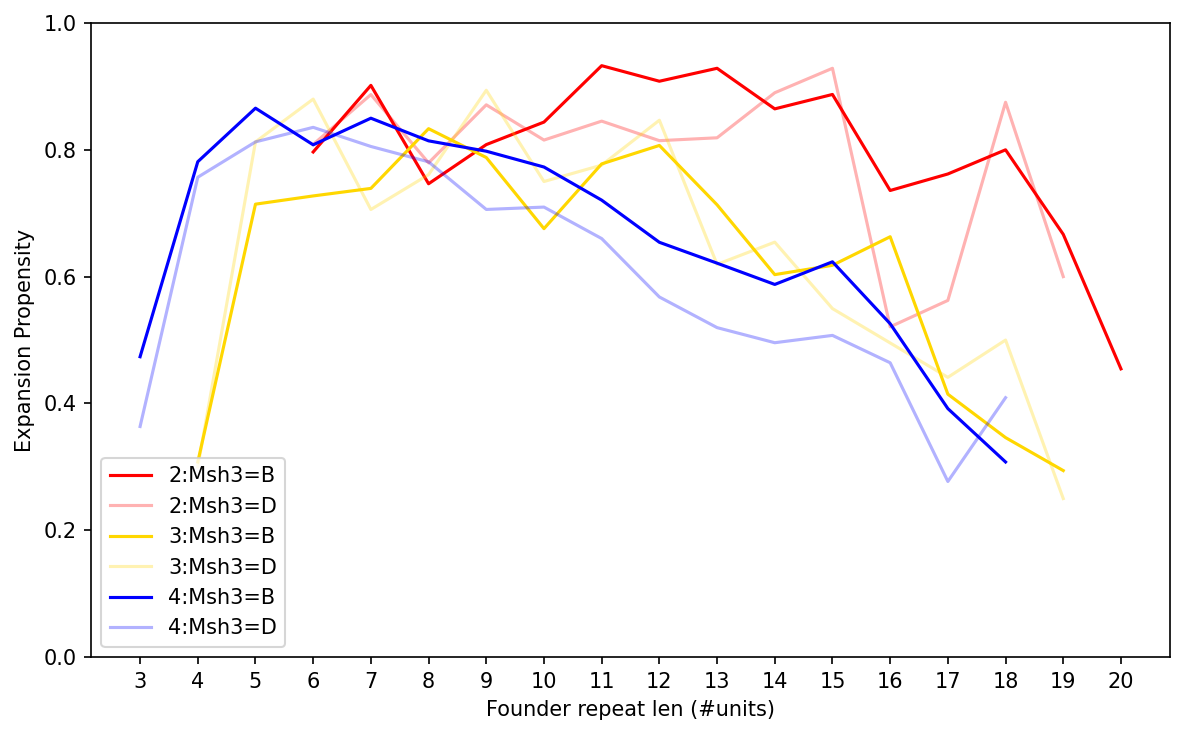

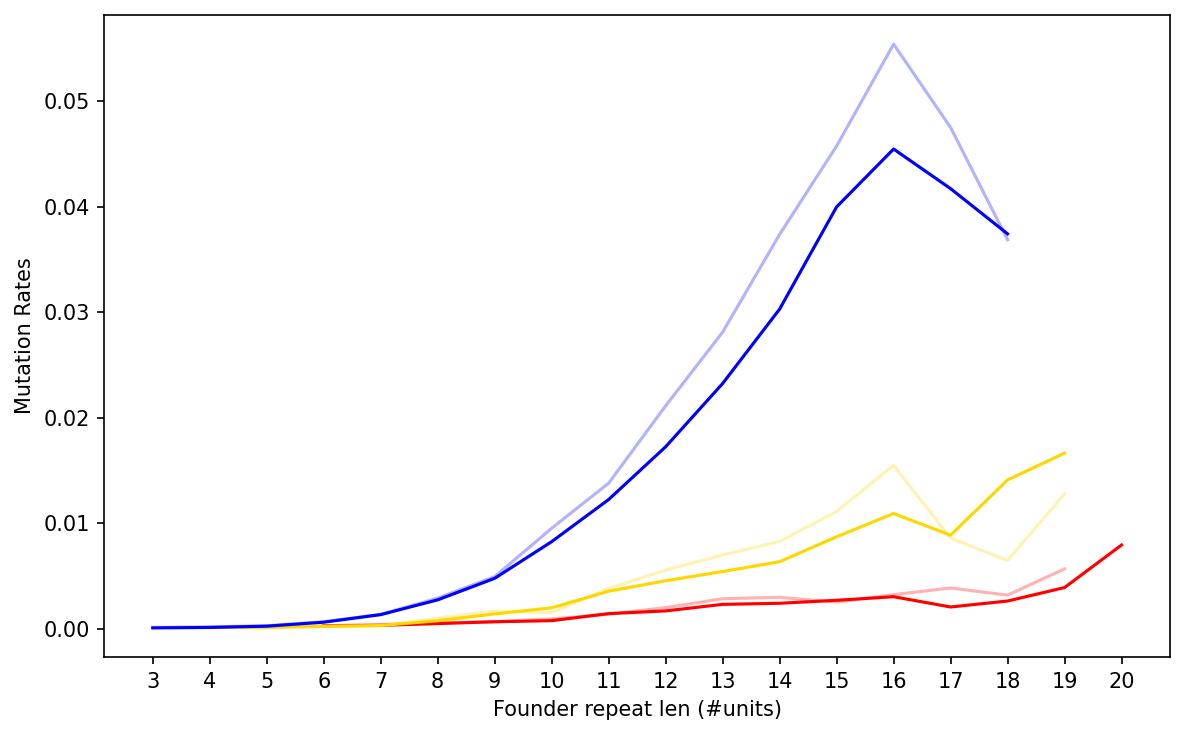

In [5]:
#### Make pattern plots for B vs. D at Msh3 locus ####

def MakePatternPlot_Combined(auto_info, metric, \
                             calls_info=None, chr13_gt=None, \
                             motif_info=None, founder_labels=None, figname=None):
    fig = plt.figure(dpi=150)
    fig.set_size_inches((8, 5))
    ax = fig.add_subplot(111)
    for period in [2, 3, 4]:
        color = percolors[period]
        for msh3 in ["B", "D"]:
            alpha = msh3line[msh3]
            y_values = []
            for replen in range(MINREP, MAXREP+1):
                #if metric == "mut_rate": print("%s %s %s"%(metric, period, replen))
                muts = auto_info[(auto_info["motif_len"]==period) & \
                                 (auto_info["fou_gt_chr13"]==msh3) & \
                                (auto_info["fou_rn"]==replen) & \
                                (auto_info["num_mut"]<=10)].copy()
                if muts.shape[0] < 10:
                    y_values.append(float("nan"))
                else:
                    if metric == "exp_prop":
                        y_values.append(np.mean(muts["expand_sign"].apply(lambda x: x==1)))
                    elif metric == "num_mut":
                        y_values.append(muts.shape[0])
                    elif metric == "contr_size": # filter out large mutations
                        y_values.append(np.mean(muts[(muts["expand_sign"]==-1) & (muts["delta_fou"]<=5)]["delta_fou"]))
                    elif metric == "exp_size":
                        y_values.append(np.mean(muts[(muts["expand_sign"]==1)  & (muts["delta_fou"]<=5)]["delta_fou"]))
                    elif metric == "mut_rate": 
                        filtset = auto_info[auto_info["num_mut"]>=10][["chr","pos"]].copy()
                        numcalls = GetNumCalls(calls_info, chr13_gt, motif_info, founder_labels, period, msh3, replen, filtset, founder="both")
                        y_values.append(muts.shape[0]/numcalls)
                    else:
                        y_values.append(float("nan"))
            ax.plot(range(MINREP, MAXREP+1), y_values, \
                     color=color, alpha=alpha, \
                    label="%s:Msh3=%s"%(period, msh3))       
        ax.set_xlabel("Founder repeat len (#units)")
        ax.set_ylabel(titles[metric])
        ax.set_xticks(range(MINREP, MAXREP+1));
        if metric == "exp_prop":
            ax.set_ylim(bottom=0, top=1)
            ax.legend(loc="lower left");
    fig.tight_layout()
    if figname is not None: fig.savefig(figname)
    
MakePatternPlot_Combined(auto_info, "exp_prop", figname="../pdfs/Fig2f.pdf")
MakePatternPlot_Combined(auto_info, "mut_rate", calls_info=calls_info, \
                         chr13_gt=chr13_gt, motif_info=motif_info, \
                         founder_labels=founder_labels, figname="../pdfs/Fig2e.pdf")

# Supplementary Figure 9 (Mutation patterns)

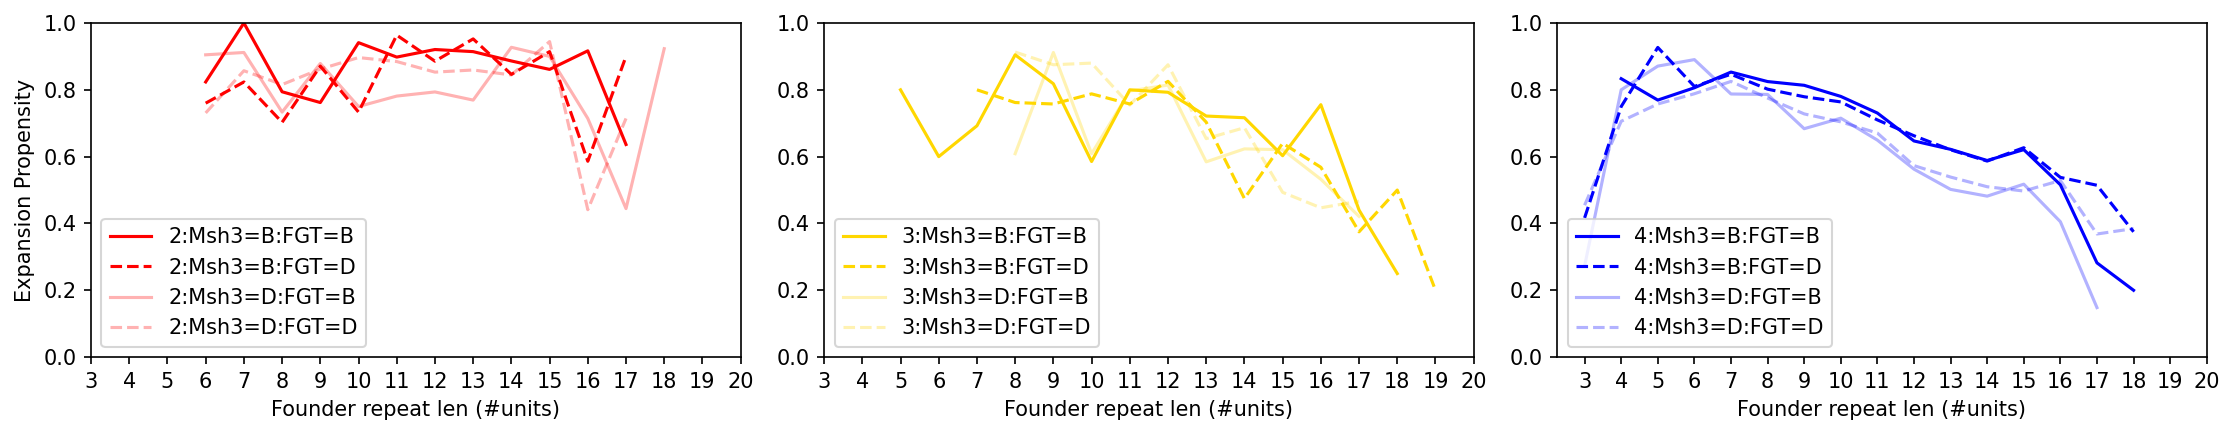

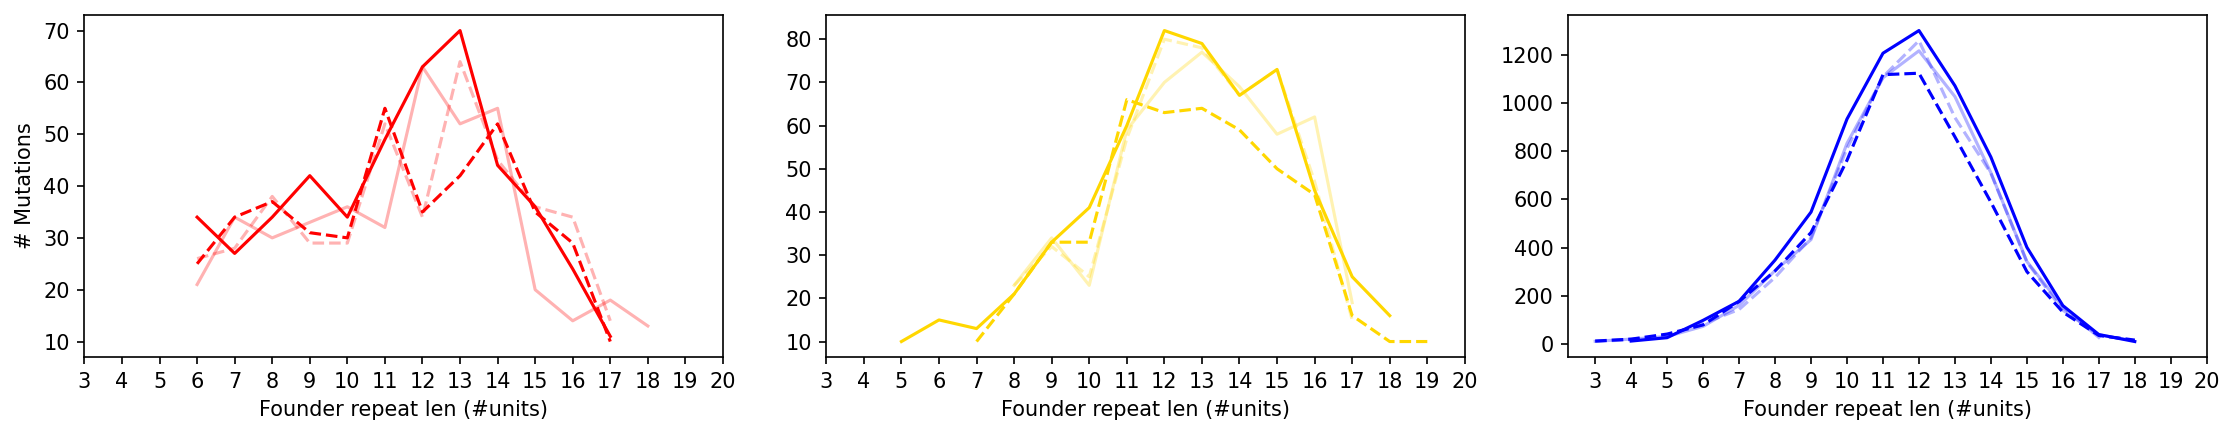

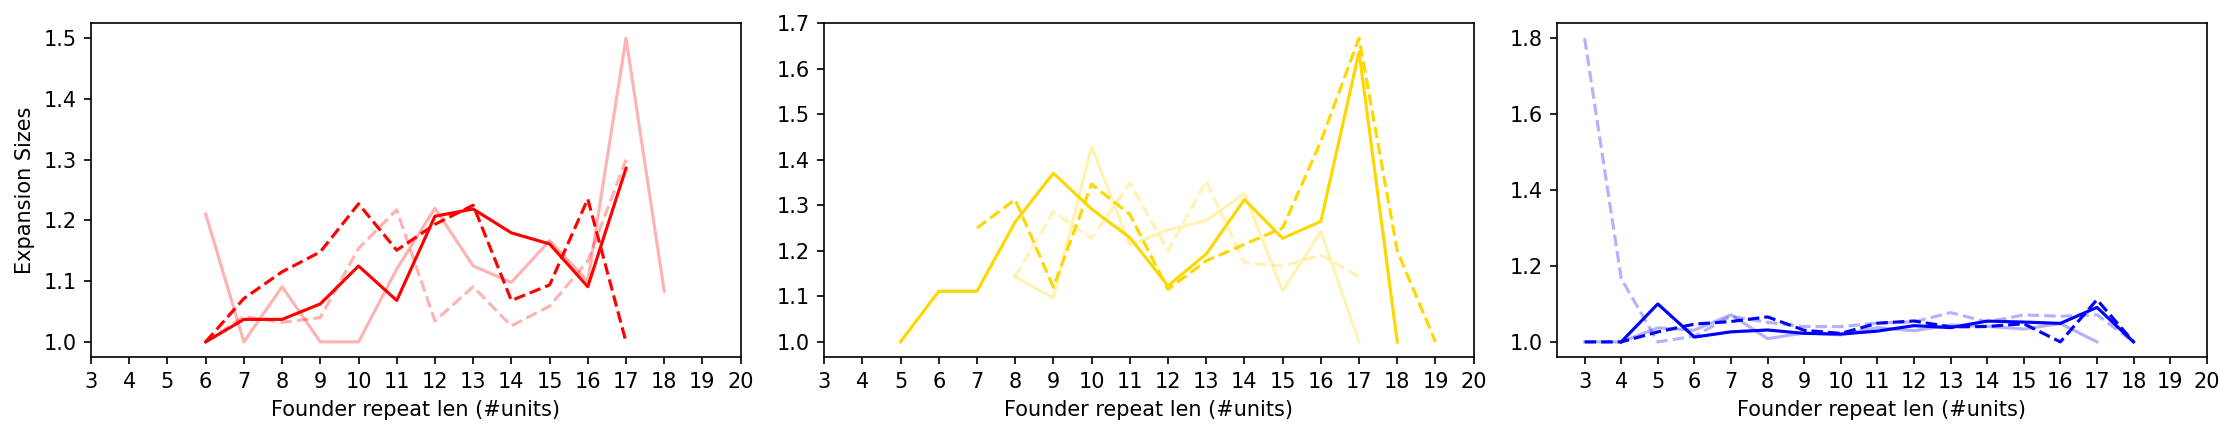

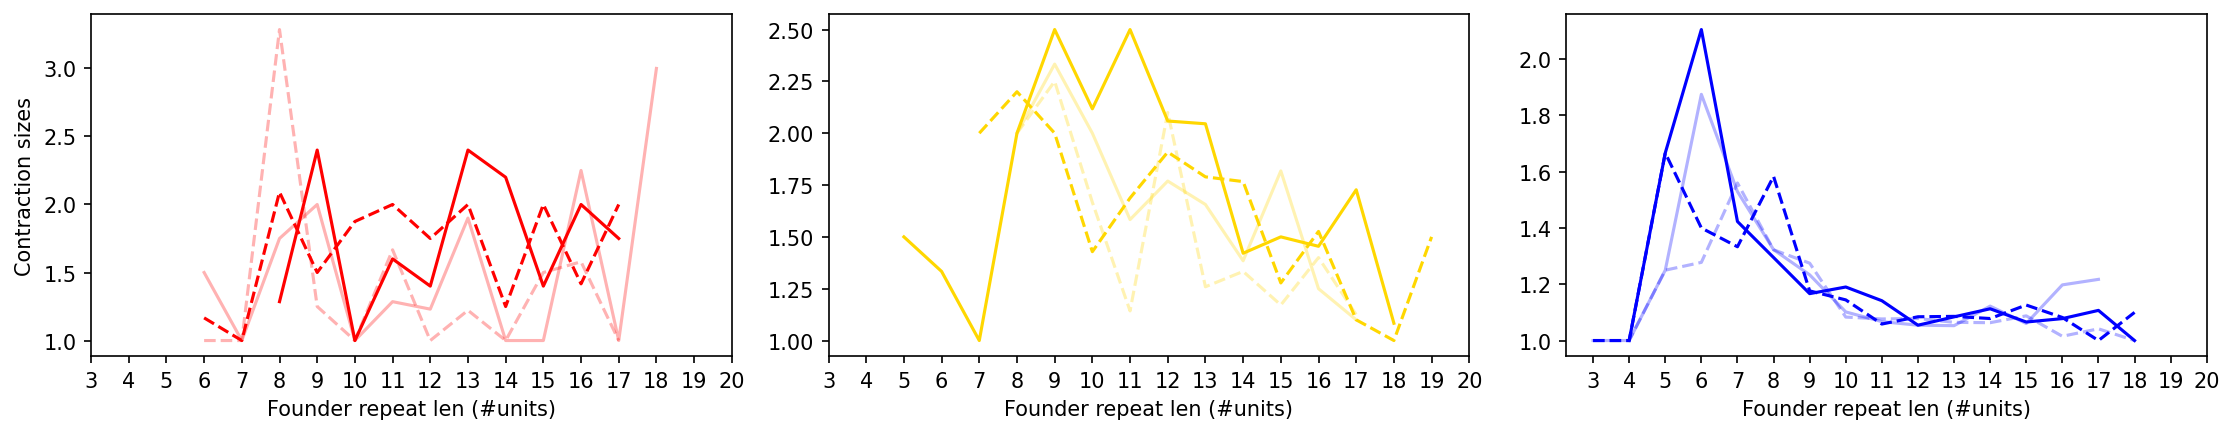

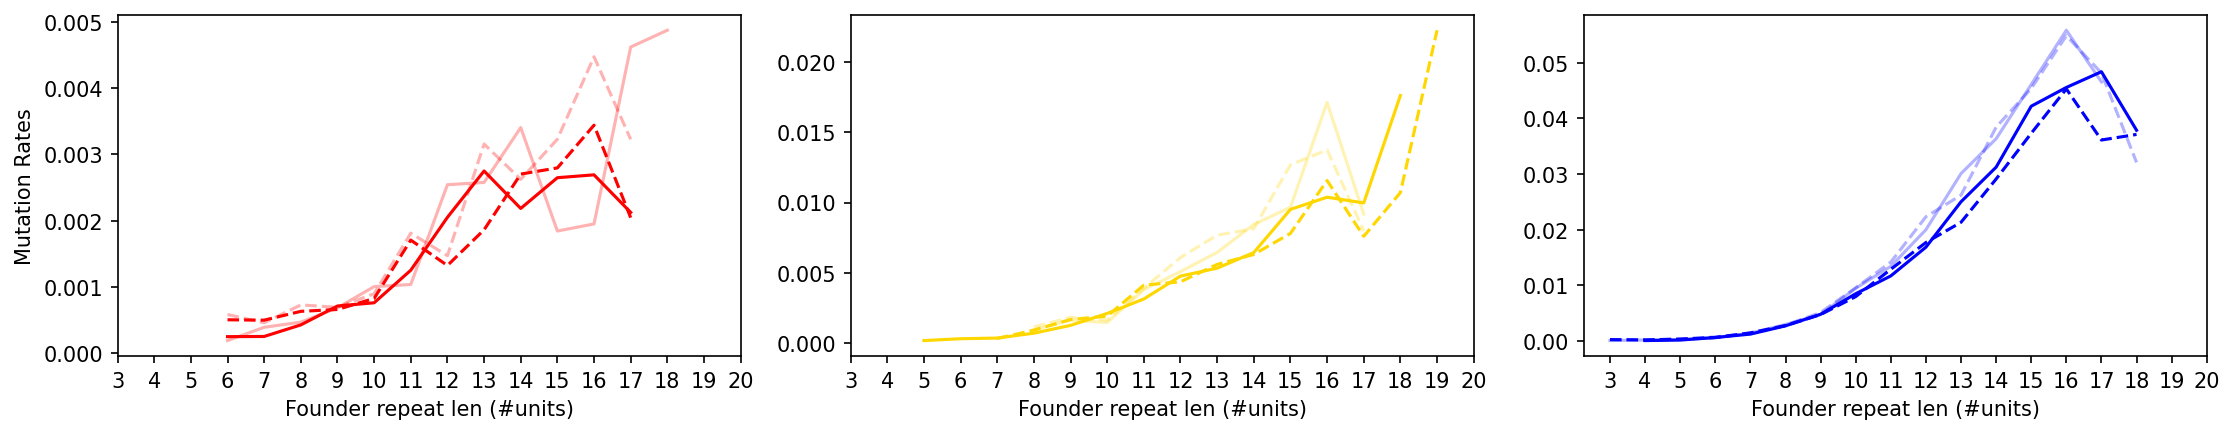

In [6]:
#### Make pattern plots for B vs. D at Msh3 locus, stratified by founder haplotype at each mutation ####
def MakePatternPlot_ByFounder(auto_info, metric, \
                                 calls_info=None, chr13_gt=None, motif_info=None, \
                                  founder_labels=None, figname=None):
    fig = plt.figure(dpi=150)
    fig.set_size_inches((15, 3))
    for period in [2, 3, 4]:
        ax1 = fig.add_subplot(1, 3, period-1)
        color = percolors[period]
        for msh3 in ["B", "D"]:
            alpha = msh3line[msh3]
            for founderGT in ["B", "D"]:
                ltype = fouline[founderGT]
                y_values = []
                for replen in range(MINREP, MAXREP+1):
                    #if metric == "mut_rate": print("%s %s %s"%(metric, period, replen))
                    muts = auto_info[(auto_info["motif_len"]==period) & \
                                 (auto_info["fou_gt_chr13"]==msh3) & \
                                 (auto_info["founder"]==founderGT) & \
                                (auto_info["fou_rn"]==replen) & \
                                (auto_info["num_mut"]<=10)].copy()
                    if muts.shape[0] < 10:
                        y_values.append(float("nan"))
                    else:
                        if metric == "exp_prop":
                            y_values.append(np.mean(muts["expand_sign"].apply(lambda x: x==1)))
                        elif metric == "num_mut":
                            y_values.append(muts.shape[0])
                        elif metric == "contr_size": # filter out large mutations
                            y_values.append(np.mean(muts[(muts["expand_sign"]==-1) & (muts["delta_fou"]<=5)]["delta_fou"]))
                        elif metric == "exp_size":
                            y_values.append(np.mean(muts[(muts["expand_sign"]==1)  & (muts["delta_fou"]<=5)]["delta_fou"]))
                        elif metric == "mut_rate":
                            filtset = auto_info[auto_info["num_mut"]>=10][["chr","pos"]].copy()
                            numcalls = GetNumCalls(calls_info, chr13_gt, motif_info, \
                                                   founder_labels, period, msh3, replen, \
                                                   filtset, founder=founderGT)
                            y_values.append(muts.shape[0]/numcalls)
                        else:
                            y_values.append(float("nan"))
                ax1.plot(range(MINREP, MAXREP+1), y_values, \
                     color=color, alpha=alpha, linestyle=ltype, \
                    label="%s:Msh3=%s:FGT=%s"%(period, msh3, founderGT))       
        ax1.set_xlabel("Founder repeat len (#units)")
        if period == 2:
            ax1.set_ylabel(titles[metric])
        ax1.set_xticks(range(MINREP, MAXREP+1));
        if metric == "exp_prop":
            ax1.set_ylim(bottom=0, top=1)
            ax1.legend(loc="lower left");
    fig.tight_layout()
    if figname is not None: fig.savefig(figname)

MakePatternPlot_ByFounder(auto_info, "exp_prop", figname="../pdfs/SuppFig8_ExpPropensity.pdf")
MakePatternPlot_ByFounder(auto_info, "num_mut", figname="../pdfs/SuppFig8_NumMut.pdf")
MakePatternPlot_ByFounder(auto_info, "exp_size", figname="../pdfs/SuppFig8_ExpSize.pdf")
MakePatternPlot_ByFounder(auto_info, "contr_size", figname="../pdfs/SuppFig8_ContrSize.pdf")
MakePatternPlot_ByFounder(auto_info, "mut_rate", calls_info=calls_info, \
                         chr13_gt=chr13_gt, motif_info=motif_info, founder_labels=founder_labels,
                         figname="../pdfs/SuppFig9_MutationRate.pdf")


# Compute stats on mutation patterns overall

In [16]:
import scipy.stats

def ComputeMutationPatternStats(auto_info, metric, \
                             calls_info=None, motif_info=None):
    for period in [2, 3, 4]:
        y_values = []
        for replen in range(MINREP, MAXREP+1):
            muts = auto_info[(auto_info["motif_len"]==period) & \
                                (auto_info["fou_rn"]==replen) & \
                                (auto_info["num_mut"]<=10)].copy()
            if muts.shape[0] < 10:
                y_values.append(float("nan"))
            else:
                if metric == "exp_prop":
                    y_values.append(np.mean(muts["expand_sign"].apply(lambda x: x==1)))
                elif metric == "num_mut":
                    y_values.append(muts.shape[0])
                elif metric == "contr_size": # filter out large mutations
                    y_values.append(np.mean(muts[(muts["expand_sign"]==-1) & (muts["delta_fou"]<=5)]["delta_fou"]))
                elif metric == "exp_size":
                    y_values.append(np.mean(muts[(muts["expand_sign"]==1)  & (muts["delta_fou"]<=5)]["delta_fou"]))
                elif metric == "mut_rate": 
                    filtset = auto_info[auto_info["num_mut"]>=10][["chr","pos"]].copy()
                    numcalls = GetNumCalls(calls_info, chr13_gt, motif_info, \
                                           founder_labels, period, None, replen, filtset, founder="both")
                    y_values.append(muts.shape[0]/numcalls)
                else:
                    y_values.append(float("nan"))
        print("Metric=%s period=%s"%(metric, period))
        xvals = list(range(MINREP, MAXREP+1))
        xvals = [xvals[i] for i in range(len(y_values)) if not np.isnan(y_values[i])]
        yvals = [y_values[i] for i in range(len(y_values)) if not np.isnan(y_values[i])]
        print(scipy.stats.pearsonr(xvals, yvals))
        
ComputeMutationPatternStats(auto_info, "exp_prop")
ComputeMutationPatternStats(auto_info, "mut_rate", calls_info=calls_info, motif_info=motif_info)

Metric=exp_prop period=2
(-0.5957503467254025, 0.019103054454337617)
Metric=exp_prop period=3
(-0.47435352907817885, 0.05437863603321306)
Metric=exp_prop period=4
(-0.6625058798517722, 0.005165577197730622)
Metric=mut_rate period=2
(0.9349578193825704, 3.2425005614600016e-07)
Metric=mut_rate period=3
(0.9354867627135621, 3.592000555021556e-08)
Metric=mut_rate period=4
(0.9328259310322906, 1.3839376706037764e-07)


# Supplementary Figure 10 (Mutation patterns by motif)

In [25]:
def plt_mutrate_motif(df, suppdata3):
    #num_mut,num_call,num_expansion
    motif_dict_B = defaultdict(lambda: [0,0,0])
    motif_dict_D = defaultdict(lambda: [0,0,0])
    motifs_mutcall = []
    
    for index, row in df.iterrows():
        motif = row['motif']
        motifs_mutcall.append(motif)
        motif_dict_B[motif][0] += row['num_B']
        motif_dict_B[motif][2] += row['expan_B']
        motif_dict_D[motif][0] += row['num_D']
        motif_dict_D[motif][2] += row['expan_D']
        
    for index, row in suppdata3.iterrows():
        motif = row['motif']
        if motif in motifs_mutcall:
            motif_dict_B[motif][1] += row['calls_B']
            motif_dict_D[motif][1] += row['calls_D']
    return motif_dict_B, motif_dict_D

def plt_mutrate_motif_byLen(df, suppdata3):
    #num_mut,num_call,num_expansion
    motif_list_B = [0,0,0]
    motif_list_D = [0,0,0]

    for index, row in df.iterrows():
        motif_list_B[0] += row['num_B']
        motif_list_B[2] += row['expan_B']
        motif_list_D[0] += row['num_D']
        motif_list_D[2] += row['expan_D']
        
    for index, row in suppdata3.iterrows():
        motif_list_B[1] += row['calls_B']
        motif_list_D[1] += row['calls_D']
    return motif_list_B, motif_list_D

def get_motif_df(motif_dict_B, motif_dict_D):
    motifs = []
    rates_B = []
    rates_D = []
    nummut_B = []
    nummut_D = []
    experc_B = []
    experc_D = []
    calls_B = []
    calls_D = []
    for key in motif_dict_B.keys():
        if (motif_dict_B[key][0] > 20) and (motif_dict_D[key][0] > 20):
            motifs.append(key)
            rates_B.append(motif_dict_B[key][0]/motif_dict_B[key][1])
            rates_D.append(motif_dict_D[key][0]/motif_dict_D[key][1])
            nummut_B.append(motif_dict_B[key][0])
            nummut_D.append(motif_dict_D[key][0])
            experc_B.append(motif_dict_B[key][2]/motif_dict_B[key][0])
            experc_D.append(motif_dict_D[key][2]/motif_dict_D[key][0])
            calls_B.append(motif_dict_B[key][1])
            calls_D.append(motif_dict_D[key][1])
    motif_df = pd.DataFrame(np.array([motifs, rates_B, rates_D, nummut_B, nummut_D, experc_B, experc_D, calls_B, calls_D]).T, columns=['motifs', 'rates_B', 'rates_D', 'nummut_B', 'nummut_D', 'experc_B', 'experc_D', 'calls_B', 'calls_D'])
    return motif_df

def get_motif_list_byLen(motif_list_B, motif_list_D, type_mut):
    rates_B = motif_list_B[0]/motif_list_B[1]
    rates_D = motif_list_D[0]/motif_list_D[1]
    nummut_B = motif_list_B[0]
    nummut_D = motif_list_D[0]
    experc_B = motif_list_B[2]/motif_list_B[0]
    experc_D = motif_list_D[2]/motif_list_D[0]
    calls_B = motif_list_B[1]
    calls_D = motif_list_D[1]
    return np.array([type_mut, rates_B, rates_D, nummut_B, nummut_D, experc_B, experc_D, calls_B, calls_D])

def get_2sample_ztestproportion(df, max_denovo_strains_per_loc, motif_len, epoch=None):
    dfB_nofilter = df[(df['min_pts_per_phe'] == 0) & (df['fou_gt'] == 'B') & (df['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df['motif_len'] == motif_len)]
    dfD_nofilter = df[(df['min_pts_per_phe'] == 0) & (df['fou_gt'] == 'D') & (df['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df['motif_len'] == motif_len)]
    n_total1 = dfB_nofilter['n'].sum()
    n_total2 = dfD_nofilter['n'].sum()
    n_mut1 = dfB_nofilter['n_mut'].sum()
    n_mut2 = dfD_nofilter['n_mut'].sum()
    stat, pval = proportions_ztest([n_mut1, n_mut2], [n_total1, n_total2])
    return stat, pval

suppdata_3_motif = pd.merge(suppdata_3, motif_info[["chr","pos","end","motif_len", "motif"]])
auto_info_collapsed = auto_info[["chr","pos","motif","motif_len","num_mut", \
                                "num_B","num_D","expan_B","expan_D",\
                                "calls_B","calls_D"]].drop_duplicates()
auto_info_filter = auto_info_collapsed[auto_info_collapsed['num_mut'] < 10]

motif_dict_2_B, motif_dict_2_D = plt_mutrate_motif(auto_info_filter[auto_info_filter['motif_len'] == 2], suppdata_3_motif[suppdata_3_motif['motif_len'] == 2])
motif_dict_3_B, motif_dict_3_D = plt_mutrate_motif(auto_info_filter[auto_info_filter['motif_len'] == 3], suppdata_3_motif[suppdata_3_motif['motif_len'] == 3])
motif_dict_4_B, motif_dict_4_D = plt_mutrate_motif(auto_info_filter[auto_info_filter['motif_len'] == 4], suppdata_3_motif[suppdata_3_motif['motif_len'] == 4])

listB, listD = plt_mutrate_motif_byLen(auto_info_filter[auto_info_filter['motif'].str.len()==2], suppdata_3_motif[suppdata_3_motif['motif_len'] == 2])
list_di = get_motif_list_byLen(listB, listD, 'di')
listB, listD = plt_mutrate_motif_byLen(auto_info_filter[auto_info_filter['motif'].str.len()==3], suppdata_3_motif[suppdata_3_motif['motif_len'] == 3])
list_tri = get_motif_list_byLen(listB, listD, 'tri')
listB, listD = plt_mutrate_motif_byLen(auto_info_filter[auto_info_filter['motif'].str.len()==4], suppdata_3_motif[suppdata_3_motif['motif_len'] == 4])
list_tetra = get_motif_list_byLen(listB, listD, 'tetra')

grouped_motifs = pd.DataFrame([list_di, list_tri, list_tetra], columns=['motifs', 'rates_B', 'rates_D', 'nummut_B', 'nummut_D', 'experc_B', 'experc_D', 'calls_B', 'calls_D'])

motif_df_2 = get_motif_df(motif_dict_2_B, motif_dict_2_D)
motif_df_3 = get_motif_df(motif_dict_3_B, motif_dict_3_D)
motif_df_4 = get_motif_df(motif_dict_4_B, motif_dict_4_D)
motif_df_all = pd.concat([motif_df_2, motif_df_3, motif_df_4, grouped_motifs], axis=0)
motif_df_all = motif_df_all.sort_values('motifs')

motif_df_all['rates_B'] = motif_df_all['rates_B'].astype(float)
motif_df_all['rates_D'] = motif_df_all['rates_D'].astype(float)
motif_df_all['nummut_B'] = motif_df_all['nummut_B'].astype(int)
motif_df_all['nummut_D'] = motif_df_all['nummut_D'].astype(int)
motif_df_all['experc_B'] = motif_df_all['experc_B'].astype(float)
motif_df_all['experc_D'] = motif_df_all['experc_D'].astype(float)
motif_df_all['calls_B'] = motif_df_all['calls_B'].astype(int)
motif_df_all['calls_D'] = motif_df_all['calls_D'].astype(int)

Exp. propensity pval - AAAC: 0.018088594231384553
Exp. propensity pval - AAAG: 0.05151513780229431
Exp. propensity pval - AAAT: 9.689269749316873e-07
Exp. propensity pval - AAC: 0.31161145662622824
Exp. propensity pval - AACC: 0.018805635446930983
Exp. propensity pval - AACT: 0.1133204461241439
Exp. propensity pval - AAGC: 0.8273179833996467
Exp. propensity pval - AAGG: 0.3222660127457597
Exp. propensity pval - AAT: 0.26372692046745194
Exp. propensity pval - AATC: 0.022688381876134336
Exp. propensity pval - AATG: 0.904481945124904
Exp. propensity pval - AC: 0.38856907440524946
Exp. propensity pval - ACAG: 0.46738106127090784
Exp. propensity pval - ACAT: 0.010497193073638474
Exp. propensity pval - ACC: 0.8121259604100596
Exp. propensity pval - ACGC: 0.09167443609084228
Exp. propensity pval - ACT: 0.49534052802243933
Exp. propensity pval - ACTC: 0.3280050950292812
Exp. propensity pval - AG: 0.03574470020023799
Exp. propensity pval - AGAT: 1.7060749363046997e-26
Exp. propensity pval - AGC

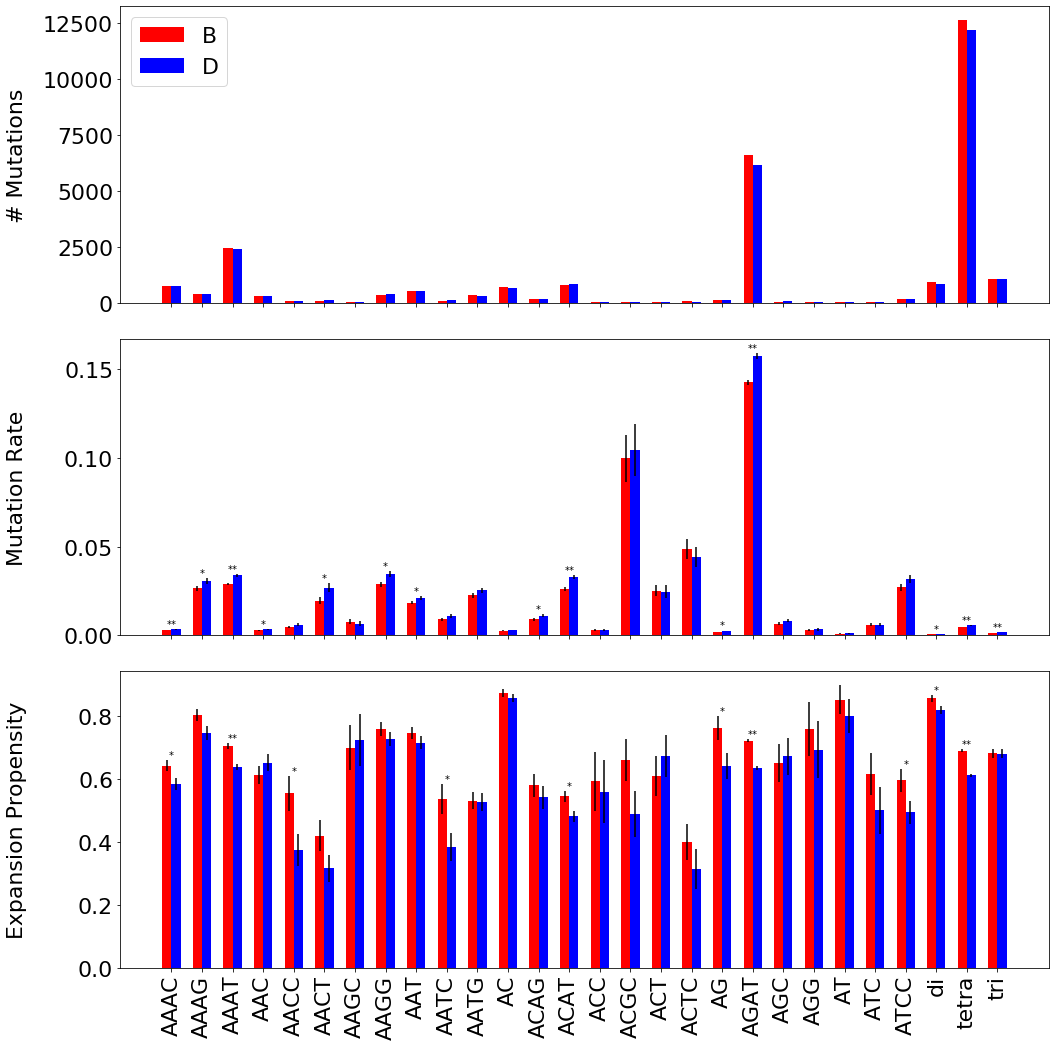

In [34]:
font = {'size'   : 22}
matplotlib.rc('font', **font)

labels = list(motif_df_all['motifs'])
rates_B = list(motif_df_all['rates_B'])
rates_D = list(motif_df_all['rates_D'])
nummut_B = list(motif_df_all['nummut_B'])
nummut_D = list(motif_df_all['nummut_D'])
experc_B = list(motif_df_all['experc_B'])
experc_D = list(motif_df_all['experc_D'])
calls_B = list(motif_df_all['calls_B'])
calls_D = list(motif_df_all['calls_D'])
# se_B = math.sqrt(perc_aggregate*(1-perc_aggregate)/n_total)
se_B = []
se_D = []
ztest_exp = []
for i in range(len(labels)):
    se_B.append(math.sqrt(experc_B[i]*(1-experc_B[i])/nummut_B[i]))
    se_D.append(math.sqrt(experc_D[i]*(1-experc_D[i])/nummut_D[i]))
    ztest_exp.append(proportions_ztest([nummut_B[i]*experc_B[i], nummut_D[i]*experc_D[i]], [nummut_B[i], nummut_D[i]]))

mutse_B = []
mutse_D = []
ztest_mut = []
for i in range(len(labels)):
    mutse_B.append(math.sqrt(rates_B[i]*(1-rates_B[i])/calls_B[i]))
    mutse_D.append(math.sqrt(rates_D[i]*(1-rates_D[i])/calls_D[i]))
    ztest_mut.append(proportions_ztest([nummut_B[i], nummut_D[i]], [calls_B[i], calls_D[i]]))

fig, ax = plt.subplots(3, figsize=(15, 15))

ax[0].bar(range(len(labels)), nummut_B, color="red", width=0.3, label='B')
ax[0].bar([item+0.3 for item in range(len(labels))], nummut_D, color="blue", width=0.3, label='D')
ax[0].set_xticks([x+0.15 for x in range(len(labels))])
ax[0].set(xticklabels=[])
ax[0].set_ylabel("# Mutations");
ax[0].legend()
ax[0].get_yaxis().set_label_coords(-0.1,0.5)

ax[1].bar(range(len(labels)), rates_B, color="red", width=0.3, label='B', yerr=mutse_B)
ax[1].bar([item+0.3 for item in range(len(labels))], rates_D, color="blue", width=0.3, label='D', yerr=mutse_D)
rects = ax[1].patches
pvals_annot = []
pvals = [x[1] for x in ztest_mut]
pvals_bonf = [x*len(pvals) for x in pvals]
for i in range(len(pvals)):
    if pvals_bonf[i] < 0.05:
        pvals_annot.append('**')
    elif pvals[i] < 0.05:
        pvals_annot.append('*')
    else:
        pvals_annot.append('')

rects_D = rects[1:]

for rect, rate_D, pval, l_height, annot_star in zip(rects, rates_D, pvals, mutse_D, pvals_annot):
    height = rate_D
    ax[1].text(rect.get_x() + rect.get_width(), height+(l_height), annot_star , ha="center", va="bottom", fontsize=10)
    
ax[1].set_xticks([x+0.15 for x in range(len(labels))])
ax[1].set(xticklabels=[])
ax[1].set_ylabel("Mutation Rate");
ax[1].get_yaxis().set_label_coords(-0.1,0.5)

ax[2].bar(range(len(labels)), experc_B, color="red", width=0.3, label='B', yerr=se_B)
ax[2].bar([item+0.3 for item in range(len(labels))], experc_D, color="blue", width=0.3, label='D', yerr=se_D)
rects = ax[2].patches
pvals_annot = []
pvals = [x[1] for x in ztest_exp]
pvals_bonf = [x*len(pvals) for x in pvals]
for i in range(len(pvals)):
    print("Exp. propensity pval - %s: %s"%(labels[i], pvals[i]))
    if pvals_bonf[i] < 0.05:
        pvals_annot.append('**')
    elif pvals[i] < 0.05:
        pvals_annot.append('*')
    else:
        pvals_annot.append('')

for rect, pval, l_height, annot_star in zip(rects, pvals, se_B, pvals_annot):
    height = rect.get_height()
    ax[2].text(rect.get_x() + rect.get_width(), height+(l_height), annot_star , ha="center", va="bottom", fontsize=10)

ax[2].set_xticks([x+0.15 for x in range(len(labels))])
ax[2].set_xticklabels(labels, rotation=90);
ax[2].set_ylabel("Expansion Propensity");
ax[2].get_yaxis().set_label_coords(-0.1,0.5)
plt.tight_layout()
plt.savefig('../pdfs/SuppFig10_MotifInfo.pdf', bbox_inches='tight') 